In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

#from model.unet.unet_model import UNet
#from model.segnet.segnet_model import SegNet
#from torchvision.models.segmentation import deeplabv3_resnet101 as DeepLabv3
from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50

#Image_Size = [384, 1242]
Image_Size = [384, 1216]
#Image_Size = [384,384]
Gradient_Clipping = 0.8

#Num_Class = 31
#Num_Class = 21
Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'unet'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = False
checkpoint_dir = '../trained'
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)

dir_checkpoint = Path(checkpoint_dir)

train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.RandomGamma(p=0.5),
        #A.RandomSnow(p=0.5),
        #A.RandomRain(p=0.5),
        #A.RandomFog(p=0.5),
        #A.RandomSunFlare(p=0.5),
        A.RandomShadow(p=0.5),
        #A.RandomToneCurve(p=0.5),
        #A.GaussNoise(p=0.5),
        #A.Emboss(p=0.5),  # IAAEmboss 대신 Emboss 사용
        #A.Perspective(p=0.5),  # IAAPerspective 대신 Perspective 사용
        #A.CLAHE(p=0.5)
])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent, train_transform)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 845.20it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    voting_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
else:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss


def forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']

        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels


        if model_name == 'ensemble_voting':
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
        else:
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)

    
    optimizer.zero_grad(set_to_none=True)
    if model_name == 'ensemble_voting':
        for pred, loss in zip([unet_pred, segnet_pred, enet_pred], [unet_loss, segnet_loss, enet_loss]):
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()
        
        return model, unet_loss, segnet_loss, enet_loss
    else:
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score)
                TrainLoss_list1.append(unet_loss)
                valScore_list2.append(segnet_val_score)
                TrainLoss_list2.append(segnet_loss)                
                valScore_list3.append(enet_val_score)
                TrainLoss_list3.append(enet_loss)
                valScore_list4.append(voting_val_score)
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                
                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

                #valScore_list.append(val_score)
                #TrainLoss_list.append(loss)
                #print('Validation Dice score: {}'.format(val_score))
                                
        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:09<00:00, 44.39img/s]

***
unet Loss: 0.2785871624946594


Epoch 1/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.23img/s]


---
unet Validation Dice Loss: 4.9727888107299805
unet Validation Pixel Accuracy: 0.1706524229886239
unet Validation MIoU: 0.08881281264781367
unet Validation Dice Score: 0.28925782442092896


Epoch 2/50:  99%|█████████▊| 200/203 [00:06<00:00, 44.17img/s]

***
unet Loss: 0.24681764841079712


Epoch 2/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.34img/s]


---
unet Validation Dice Loss: 0.3486999273300171
unet Validation Pixel Accuracy: 0.9012328030770285
unet Validation MIoU: 0.6951889108589397
unet Validation Dice Score: 0.6819146871566772


Epoch 3/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.83img/s]

***
unet Loss: 0.18592588603496552


Epoch 3/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.40img/s]


---
unet Validation Dice Loss: 0.2224142700433731
unet Validation Pixel Accuracy: 0.9421467028166118
unet Validation MIoU: 0.7944578945878549
unet Validation Dice Score: 0.7751740217208862


Epoch 4/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.76img/s]

***
unet Loss: 0.11804094910621643


Epoch 4/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.37img/s]


---
unet Validation Dice Loss: 0.3697829246520996
unet Validation Pixel Accuracy: 0.9036517226905153
unet Validation MIoU: 0.6283445843052868
unet Validation Dice Score: 0.4635227620601654


Epoch 5/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.95img/s]

***
unet Loss: 0.20367491245269775


Epoch 5/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.16img/s]


---
unet Validation Dice Loss: 0.17344486713409424
unet Validation Pixel Accuracy: 0.9556311891790021
unet Validation MIoU: 0.8468202328068176
unet Validation Dice Score: 0.818748414516449


Epoch 6/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.44img/s]

***
unet Loss: 0.15551596879959106


Epoch 6/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.32img/s]


---
unet Validation Dice Loss: 0.22450563311576843
unet Validation Pixel Accuracy: 0.9336470219126919
unet Validation MIoU: 0.7482973252862382
unet Validation Dice Score: 0.6937071681022644


Epoch 7/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.50img/s]

***
unet Loss: 0.08021218329668045


Epoch 7/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.10img/s]


---
unet Validation Dice Loss: 0.144223153591156
unet Validation Pixel Accuracy: 0.9627192982456141
unet Validation MIoU: 0.8720062078687949
unet Validation Dice Score: 0.8450838327407837


Epoch 8/50:  99%|█████████▊| 200/203 [00:06<00:00, 44.12img/s]

***
unet Loss: 0.08263613283634186


Epoch 8/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.90img/s]


---
unet Validation Dice Loss: 0.2231258898973465
unet Validation Pixel Accuracy: 0.9444357888740406
unet Validation MIoU: 0.8262005794843376
unet Validation Dice Score: 0.857118546962738


Epoch 9/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.53img/s]

***
unet Loss: 0.1983422189950943


Epoch 9/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.23img/s]


---
unet Validation Dice Loss: 0.16998983919620514
unet Validation Pixel Accuracy: 0.9538330613521108
unet Validation MIoU: 0.8267616721343071
unet Validation Dice Score: 0.8393756747245789


Epoch 10/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.95img/s]

***
unet Loss: 0.14982950687408447


Epoch 10/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.06img/s]


---
unet Validation Dice Loss: 0.16385482251644135
unet Validation Pixel Accuracy: 0.9562428792317709
unet Validation MIoU: 0.834926090744734
unet Validation Dice Score: 0.8050083518028259


Epoch 11/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.81img/s]

***
unet Loss: 0.15649524331092834


Epoch 11/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.00img/s]


---
unet Validation Dice Loss: 0.32474809885025024
unet Validation Pixel Accuracy: 0.9339088306092379
unet Validation MIoU: 0.8044198701998849
unet Validation Dice Score: 0.8541302680969238


Epoch 12/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.85img/s]

***
unet Loss: 0.0746486485004425


Epoch 12/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.25img/s]


---
unet Validation Dice Loss: 0.11178324371576309
unet Validation Pixel Accuracy: 0.9725141023334704
unet Validation MIoU: 0.896016926948455
unet Validation Dice Score: 0.881772518157959


Epoch 13/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.89img/s]

***
unet Loss: 0.07887798547744751


Epoch 13/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.88img/s]


---
unet Validation Dice Loss: 0.1080205962061882
unet Validation Pixel Accuracy: 0.971021150287829
unet Validation MIoU: 0.8971380249791503
unet Validation Dice Score: 0.9161262512207031


Epoch 14/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.16img/s]

***
unet Loss: 0.0734083503484726


Epoch 14/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.78img/s]


---
unet Validation Dice Loss: 0.11891330033540726
unet Validation Pixel Accuracy: 0.9687532123766447
unet Validation MIoU: 0.8913887956179152
unet Validation Dice Score: 0.9100757837295532


Epoch 15/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.40img/s]

***
unet Loss: 0.07687285542488098


Epoch 15/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.87img/s]


---
unet Validation Dice Loss: 0.10273062437772751
unet Validation Pixel Accuracy: 0.9736301355194628
unet Validation MIoU: 0.9038314284301636
unet Validation Dice Score: 0.9145941138267517


Epoch 16/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.59img/s]

***
unet Loss: 0.08627356588840485


Epoch 16/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.91img/s]


---
unet Validation Dice Loss: 0.1412535458803177
unet Validation Pixel Accuracy: 0.9654048451206141
unet Validation MIoU: 0.8827417169298613
unet Validation Dice Score: 0.9049447178840637


Epoch 17/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.63img/s]

***
unet Loss: 0.10988464951515198


Epoch 17/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.98img/s]


---
unet Validation Dice Loss: 0.10751500725746155
unet Validation Pixel Accuracy: 0.9715463738692435
unet Validation MIoU: 0.8994987014024947
unet Validation Dice Score: 0.9210681915283203


Epoch 18/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.41img/s]

***
unet Loss: 0.054870445281267166


Epoch 18/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.31img/s]


---
unet Validation Dice Loss: 0.10299976915121078
unet Validation Pixel Accuracy: 0.9720493785121984
unet Validation MIoU: 0.9001628908696473
unet Validation Dice Score: 0.9234232902526855


Epoch 19/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.64img/s]

***
unet Loss: 0.05178464949131012


Epoch 19/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.96img/s]


---
unet Validation Dice Loss: 0.10572373121976852
unet Validation Pixel Accuracy: 0.9716922693085253
unet Validation MIoU: 0.8994339567650778
unet Validation Dice Score: 0.9245128035545349


Epoch 20/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.61img/s]

***
unet Loss: 0.05418263375759125


Epoch 20/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.11img/s]


---
unet Validation Dice Loss: 0.10723420232534409
unet Validation Pixel Accuracy: 0.9712901868318257
unet Validation MIoU: 0.8981822225221692
unet Validation Dice Score: 0.922413170337677


Epoch 21/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.58img/s]

***
unet Loss: 0.07054080069065094


Epoch 21/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.46img/s]


---
unet Validation Dice Loss: 0.10944182425737381
unet Validation Pixel Accuracy: 0.9708674916049891
unet Validation MIoU: 0.8970127088482762
unet Validation Dice Score: 0.9229103922843933


Epoch 22/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.28img/s]

***
unet Loss: 0.05824597552418709


Epoch 22/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.20img/s]


---
unet Validation Dice Loss: 0.10842502862215042
unet Validation Pixel Accuracy: 0.9711078844572368
unet Validation MIoU: 0.8976006718615275
unet Validation Dice Score: 0.9228413701057434


Epoch 23/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.03img/s]

***
unet Loss: 0.07160719484090805


Epoch 23/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.19img/s]


---
unet Validation Dice Loss: 0.11144664883613586
unet Validation Pixel Accuracy: 0.9706099660773027
unet Validation MIoU: 0.896330347589651
unet Validation Dice Score: 0.922122597694397


Epoch 24/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.79img/s]

***
unet Loss: 0.06587763130664825


Epoch 24/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.54img/s]


---
unet Validation Dice Loss: 0.10629215091466904
unet Validation Pixel Accuracy: 0.971435546875
unet Validation MIoU: 0.8983785745488614
unet Validation Dice Score: 0.9227706789970398


Epoch 25/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.39img/s]

***
unet Loss: 0.08362270891666412


Epoch 25/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.02img/s]


---
unet Validation Dice Loss: 0.10946003347635269
unet Validation Pixel Accuracy: 0.9712896514357182
unet Validation MIoU: 0.8985011526002624
unet Validation Dice Score: 0.9236664772033691


Epoch 26/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.84img/s]

***
unet Loss: 0.10234377533197403


Epoch 26/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.09img/s]


---
unet Validation Dice Loss: 0.10734384506940842
unet Validation Pixel Accuracy: 0.9716293602658991
unet Validation MIoU: 0.8994807804592604
unet Validation Dice Score: 0.9231082797050476


Epoch 27/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.84img/s]

***
unet Loss: 0.06140025705099106


Epoch 27/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.06img/s]


---
unet Validation Dice Loss: 0.10828053206205368
unet Validation Pixel Accuracy: 0.9713844165467379
unet Validation MIoU: 0.8986852985970161
unet Validation Dice Score: 0.9227588772773743


Epoch 28/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.65img/s]

***
unet Loss: 0.11047236621379852


Epoch 28/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.22img/s]


---
unet Validation Dice Loss: 0.10805301368236542
unet Validation Pixel Accuracy: 0.9714566950212445
unet Validation MIoU: 0.8989322180462795
unet Validation Dice Score: 0.9233129620552063


Epoch 29/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.73img/s]

***
unet Loss: 0.04940667748451233


Epoch 29/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.78img/s]


---
unet Validation Dice Loss: 0.10509490966796875
unet Validation Pixel Accuracy: 0.971746612013432
unet Validation MIoU: 0.8994209755087381
unet Validation Dice Score: 0.9238461852073669


Epoch 30/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.01img/s]

***
unet Loss: 0.0767020583152771


Epoch 30/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.10img/s]


---
unet Validation Dice Loss: 0.10716746002435684
unet Validation Pixel Accuracy: 0.9715415553042763
unet Validation MIoU: 0.899032510357513
unet Validation Dice Score: 0.9233589172363281


Epoch 31/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.84img/s]

***
unet Loss: 0.0528210885822773


Epoch 31/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.29img/s]


---
unet Validation Dice Loss: 0.10973998159170151
unet Validation Pixel Accuracy: 0.9713464034231085
unet Validation MIoU: 0.8988978829885061
unet Validation Dice Score: 0.9239768981933594


Epoch 32/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.68img/s]

***
unet Loss: 0.08052999526262283


Epoch 32/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.37img/s]


---
unet Validation Dice Loss: 0.10744380205869675
unet Validation Pixel Accuracy: 0.9717313532243695
unet Validation MIoU: 0.8998387936423864
unet Validation Dice Score: 0.9239832758903503


Epoch 33/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.32img/s]

***
unet Loss: 0.06958882510662079


Epoch 33/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.30img/s]


---
unet Validation Dice Loss: 0.10778261721134186
unet Validation Pixel Accuracy: 0.9716049997430098
unet Validation MIoU: 0.8993433759046003
unet Validation Dice Score: 0.9235361218452454


Epoch 34/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.76img/s]

***
unet Loss: 0.052921418100595474


Epoch 34/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.12img/s]


---
unet Validation Dice Loss: 0.11079899966716766
unet Validation Pixel Accuracy: 0.9708996153714364
unet Validation MIoU: 0.8973903631185611
unet Validation Dice Score: 0.9221799969673157


Epoch 35/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.93img/s]

***
unet Loss: 0.06321099400520325


Epoch 35/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.40img/s]


---
unet Validation Dice Loss: 0.11331142485141754
unet Validation Pixel Accuracy: 0.970403838575932
unet Validation MIoU: 0.8959367717608604
unet Validation Dice Score: 0.9221439361572266


Epoch 36/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.66img/s]

***
unet Loss: 0.14426079392433167


Epoch 36/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.99img/s]


---
unet Validation Dice Loss: 0.10785139352083206
unet Validation Pixel Accuracy: 0.9714411685341283
unet Validation MIoU: 0.8988538493920308
unet Validation Dice Score: 0.9228801131248474


Epoch 37/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.76img/s]

***
unet Loss: 0.07508363574743271


Epoch 37/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.04img/s]


---
unet Validation Dice Loss: 0.11156852543354034
unet Validation Pixel Accuracy: 0.9709081817091557
unet Validation MIoU: 0.8975487598176536
unet Validation Dice Score: 0.9231082201004028


Epoch 38/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.52img/s]

***
unet Loss: 0.06614682078361511


Epoch 38/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.29img/s]


---
unet Validation Dice Loss: 0.11444026231765747
unet Validation Pixel Accuracy: 0.9705350106222588
unet Validation MIoU: 0.8968184316991712
unet Validation Dice Score: 0.9227695465087891


Epoch 39/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.80img/s]

***
unet Loss: 0.09514922648668289


Epoch 39/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.89img/s]


---
unet Validation Dice Loss: 0.10803249478340149
unet Validation Pixel Accuracy: 0.9714644582648027
unet Validation MIoU: 0.8989210819066953
unet Validation Dice Score: 0.9227545857429504


Epoch 40/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.73img/s]

***
unet Loss: 0.07669876515865326


Epoch 40/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.13img/s]


---
unet Validation Dice Loss: 0.11075728386640549
unet Validation Pixel Accuracy: 0.9709095201994243
unet Validation MIoU: 0.8973732957557541
unet Validation Dice Score: 0.9226703643798828


Epoch 41/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.49img/s]

***
unet Loss: 0.05402377247810364


Epoch 41/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.29img/s]


---
unet Validation Dice Loss: 0.10975316911935806
unet Validation Pixel Accuracy: 0.9712805497018915
unet Validation MIoU: 0.8985761406878251
unet Validation Dice Score: 0.9240886569023132


Epoch 42/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.62img/s]

***
unet Loss: 0.04713322967290878


Epoch 42/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.96img/s]


---
unet Validation Dice Loss: 0.10959124565124512
unet Validation Pixel Accuracy: 0.9710803115577028
unet Validation MIoU: 0.8977895763414558
unet Validation Dice Score: 0.9228504300117493


Epoch 43/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.49img/s]

***
unet Loss: 0.06268016248941422


Epoch 43/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.23img/s]


---
unet Validation Dice Loss: 0.11113134026527405
unet Validation Pixel Accuracy: 0.9708875689590186
unet Validation MIoU: 0.8974423974940181
unet Validation Dice Score: 0.9222555160522461


Epoch 44/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.41img/s]

***
unet Loss: 0.08566395938396454


Epoch 44/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.97img/s]


---
unet Validation Dice Loss: 0.10695160925388336
unet Validation Pixel Accuracy: 0.9717112758703399
unet Validation MIoU: 0.8995941022671556
unet Validation Dice Score: 0.923345685005188


Epoch 45/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.40img/s]

***
unet Loss: 0.04381560534238815


Epoch 45/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.34img/s]


---
unet Validation Dice Loss: 0.10745956003665924
unet Validation Pixel Accuracy: 0.971463119774534
unet Validation MIoU: 0.89887746508333
unet Validation Dice Score: 0.9232885241508484


Epoch 46/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.35img/s]

***
unet Loss: 0.07773017883300781


Epoch 46/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.04img/s]


---
unet Validation Dice Loss: 0.1080072671175003
unet Validation Pixel Accuracy: 0.9713464034231085
unet Validation MIoU: 0.8984420571763321
unet Validation Dice Score: 0.9229836463928223


Epoch 47/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.50img/s]

***
unet Loss: 0.051169585436582565


Epoch 47/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.81img/s]


---
unet Validation Dice Loss: 0.10895391553640366
unet Validation Pixel Accuracy: 0.9711346542626097
unet Validation MIoU: 0.8978926778303948
unet Validation Dice Score: 0.9225514531135559


Epoch 48/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.61img/s]

***
unet Loss: 0.06418478488922119


Epoch 48/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.53img/s]


---
unet Validation Dice Loss: 0.10969158262014389
unet Validation Pixel Accuracy: 0.9712591338575932
unet Validation MIoU: 0.8984820082555376
unet Validation Dice Score: 0.9234115481376648


Epoch 49/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.12img/s]

***
unet Loss: 0.0706486850976944


Epoch 49/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.14img/s]


---
unet Validation Dice Loss: 0.1090010330080986
unet Validation Pixel Accuracy: 0.9713051779228344
unet Validation MIoU: 0.8984867652660078
unet Validation Dice Score: 0.9231002926826477


Epoch 50/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.17img/s]

***
unet Loss: 0.07676151394844055


Epoch 50/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.95img/s]

---
unet Validation Dice Loss: 0.10932622104883194
unet Validation Pixel Accuracy: 0.9712810850979989
unet Validation MIoU: 0.8984990006857608
unet Validation Dice Score: 0.9236323237419128


valScore_list1
TrainLoss_list1
val_losses

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']

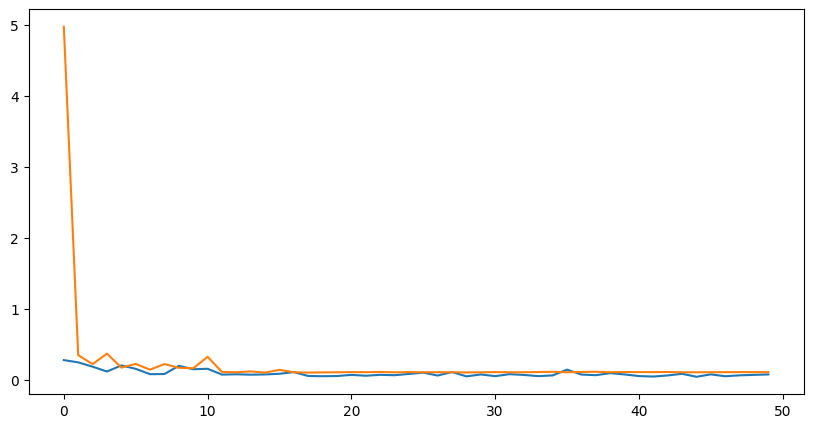

In [16]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)
#plt.show()

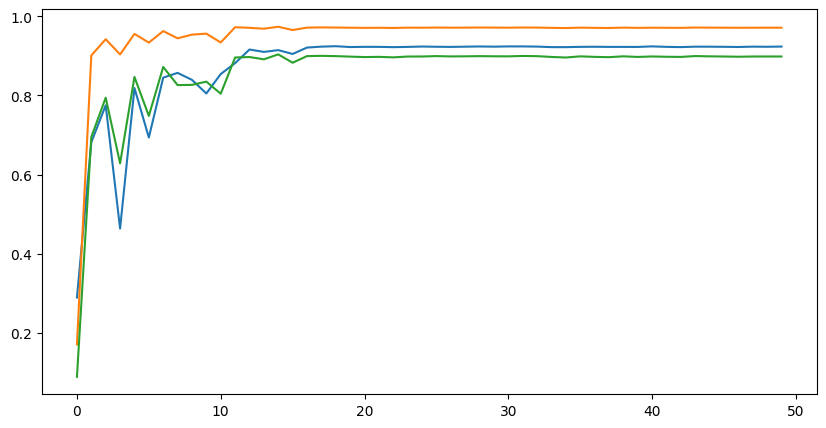

In [18]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)
#plt.show()

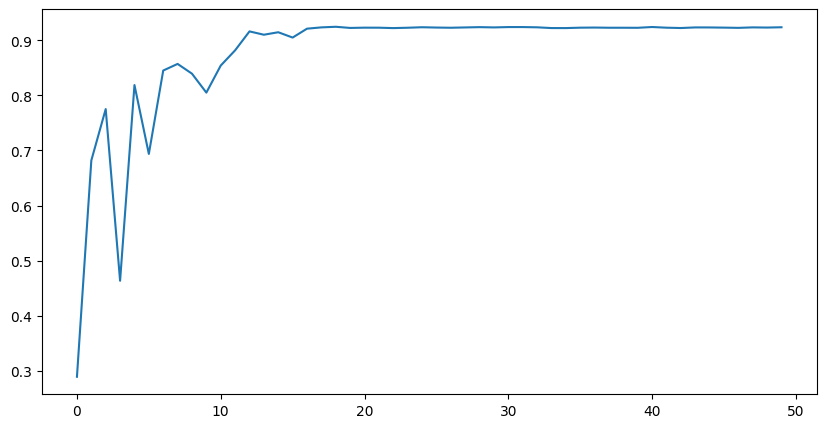

In [17]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)